In [ ]:
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
#Scraping initial data
url = 'https://www.temptalia.com/category/reviews/page/1'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page, "lxml")
links = soup.find_all(class_='btn btn-secondary btn-lg more-link')
for link in links:
    print(link.get('href'))
url_list = (list(range(1,1790)))
product_links = []
for url_end in url_list:
    url = ('https://www.temptalia.com/category/reviews/page/' + str(url_end))
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    links = soup.find_all(class_='btn btn-secondary btn-lg more-link')
    for link in links:
        product_links.append(link.get('href'))
import csv
with open("output.csv","w") as outFile:
    wr = csv.writer(outFile)
    wr.writerows(product_links)
    names = set()
reviews = set()
grades = []
for link in product_links:
    response = requests.get(link)
    soup = BeautifulSoup(response.text, "lxml")
    product_names = soup.find_all('figcaption')
    product_reviews = (soup.find_all('p'))
    product_grades = (soup.find_all(class_ = 'glossover-grade f-7 bold'))
    for product in product_names:
        if "Look Details" not in product.text:
            current_prod = product.text
            print(product.text)
            names.add(product.text)
            for review in product_reviews:
                if current_prod in review.text:
                    print(review.text)
                    reviews.add(review.text)
    for review in product_reviews:
        if review.find(class_ = 'shadereview') != None:
            print(review.text)
            reviews.add(review.text)
    for grade in product_grades:
        print(grade.text)
        grades.append(grade.text)
        

In [ ]:
#Making Dataframe of scraped data
names = list(names)
reviews = list(reviews)
df = pd.DataFrame(data = {'review_text': reviews, 'score': grades[:14767]})
df.to_csv('output.csv')

In [ ]:
#Basic Data Cleaning
import re
df['review_text'] = df['review_text'].str.replace('\n', '')
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
products = []
for i in range(len(df)):
    product = re.findall('^(.*?)(\s*\sis|includes|consists|contains|are|has|include|pairs|was|comes|features|will|come|appears|make|blends)', df['review_text'].iloc[i])
    if product != []:
        products.append(product[0][0])
    else:
        products.append('unknown')
df['product_name'] = products
prices = []
for i in range(len(df)):
    price = re.search(r'\((.*?)\)',df['product_name'].iloc[i])
    print (i)
    if price != None:
        prices.append(price.group(1))
    else:
        prices.append('unknown')
df['prices'] = prices
clean_names = []
for i in range(len(df)):
    name = df['product_name'].iloc[i].replace(f'({df.prices.iloc[i]})', '')
    clean_names.append(name)
df['clean_names'] = clean_names
df.to_csv('output_clean.csv')

In [ ]:
#Reading in cleaned data
df = pd.read_csv('output_clean.csv')
df = df.replace(np.nan, '', regex=True)
df = df[['review_text', 'score', 'product_name', 'prices', 'clean_names']]

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=329618517)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_count = count_vect.fit_transform(train['product_name'])
X_train_count.shape

In [ ]:
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
n_comp = 20
NMF_count = NMF(n_components=n_comp)

NMF_count_data = NMF_count.fit_transform(X_train_count)

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def return_tokens(document):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(document)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    return filtered_sentence

In [ ]:
tokenized_reviews = []
for item in train['review_text'].values.astype('U'):
    tokenized_reviews.append(return_tokens(item))

In [ ]:
from sklearn.neighbors import NearestNeighbors
# def get_recommendation(first_article, model, vectorizer, training_vectors):
#     new_vec = model.transform(vectorizer.transform([first_article]))
#     nn = NearestNeighbors(n_neighbors=1, metric='cosine', algorithm='brute')
#     nn.fit(training_vectors)
#     results = nn.kneighbors(new_vec)
#     return results[1][0]

# print(get_recommendation(sample_review, NMF_count, count_vect, NMF_count_data))

In [ ]:
train['review_text'].iloc[546]

In [ ]:
#Extacting product categories/labels
def extract_cats(dataframe, cats):
    for cat in cats:
        dataframe['type'][dataframe['review_text'].map(lambda x: x.lower()).str.contains(cat)] = cat

In [ ]:
train['type'] = ''
types = ['lipstick','gloss','eyeshadow']
extract_cats(train, types)

In [2453]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

In [2454]:
labeled = train.loc[train['type'] != '']

In [2455]:
x_label_train = labeled['review_text']
y_label_train = labeled['type']

In [2456]:
train['type'].unique()

array(['eyeshadow', 'gloss', 'lipstick'], dtype=object)

In [2457]:
vectorizer = TfidfVectorizer(stop_words='english')
label_train_vect = vectorizer.fit_transform(x_label_train)

In [2458]:
clf = svm.LinearSVC()
clf.fit(label_train_vect, y_label_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [2459]:
clf.score(label_train_vect, y_label_train)

0.9988147646461226

In [2460]:
for i in range(len(train)):
    train['type'].iloc[i] == ''
    train['type'].iloc[i] = clf.predict(vectorizer.transform([train['review_text'].iloc[i]]))[0]

/Users/chelan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [2461]:
#Retraining model/populate whole df
Xtrain_vect = vectorizer.fit_transform(train['review_text'])
clf = svm.LinearSVC()
clf.fit(Xtrain_vect, train['type'])
for i in range(len(df)):
    df['type'].iloc[i] = clf.predict(vectorizer.transform([df['review_text'].iloc[i]]))

/Users/chelan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [2462]:
set([x[0] for x in df['type']])

{'eyeshadow', 'gloss', 'lipstick'}

In [2463]:
from nltk import pos_tag
df['adjs'] = ''
for i in range(len(df)):
    df['adjs'].iloc[i] = [x[0] for x in pos_tag(return_tokens(df['review_text'].iloc[i])) if x[1] == 'JJ']                                               

/Users/chelan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [2464]:
def do_nothing(tokens):
    return tokens

In [2465]:
def better_rec(text, data):
    adjs = [x[0] for x in pos_tag(return_tokens(text)) if x[1] == 'JJ']
    print(adjs)
    count_vect = CountVectorizer(tokenizer=do_nothing,
                             preprocessor=None,
                             lowercase=False)
    adj_vect = count_vect.fit_transform(data['review_text'])
    NMF_count_data = NMF_count.fit_transform(adj_vect)
    new_vec = NMF_count.transform(count_vect.transform(adjs))
    nn = NearestNeighbors(n_neighbors=1, metric='cosine', algorithm='brute')
    nn.fit(NMF_count_data)
    results = nn.kneighbors(new_vec)
    print(data['adjs'].iloc[results[1][0][0]])
    return data.iloc[results[1][0][0]]

In [2466]:
sample_review = 'glittery eyeshadow, shiny, sparkles multicolored, long-lasting'
data = df[(df['type']=='eyeshadow') & (df['price']< 25.00) & (df['price']> 0)]
better_rec(sample_review, data)

['long-lasting']
['various', 'greenish', 'navy', 'grassy']


review_text     Wet ‘n’ Wild Earth Looks Small From Down Here ...
score                                                        \nB 
product_name    Wet ‘n’ Wild Earth Looks Small From Down Here ...
prices                                                         -1
clean_names     Wet ‘n’ Wild Earth Looks Small From Down Here ...
type                                                  [eyeshadow]
adjs                            [various, greenish, navy, grassy]
price_substr    Wet ‘n’ Wild Earth Looks Small From Down Here ...
price                                                        2.99
Name: 12273, dtype: object

In [2467]:
df_new = df.groupby('product_name').adjs.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)

In [2468]:
data_frame_trimmed2 = df_new.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [2469]:
data_frame_trimmed['adjs'] = df['adjs']

In [2470]:
data_frame_trimmed2.head()

,product_name,0
0,Blue Velvet,medium-dark
1,Blue Velvet,soft
2,Blue Velvet,dusty
3,Blue Velvet,luminous
4,Blue Velvet,finish


In [2471]:
data_frame_trimmed.to_csv('labeled_output.csv')

In [2472]:
data_frame_trimmed2.to_csv('desc_output.csv')

In [2473]:
df['review_text'][df['review_text'].str.contains(' g')].sample(n=5)

4248     Indo is described as an “emerald.” It’s a cool...
43       Riot is described as “smoky gray matte with vi...
11841    Foreshadow is a taupe brown with subtle, warm ...
11768    Riviera is a light, golden beige with warm und...
3063     MAC Satin Shimmer Mineralize Skinfinish ($33.0...
Name: review_text, dtype: object

In [2474]:
df['review_text'].iloc[6284]

'Flutterbye is a bright, medium coral-orange with warm undertones and a matte finish. It had rich color payoff with a soft, blendable texture that wasn’t too soft nor was it too firm on the pan. This shade wore well for eight hours on me.'

In [2475]:
df[df['prices'].str.contains('Not') == False & df['prices'].str.contains('\$')]

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

In [2476]:
clf.score(Xtrain_vect, train['type'])

0.9997460209955977

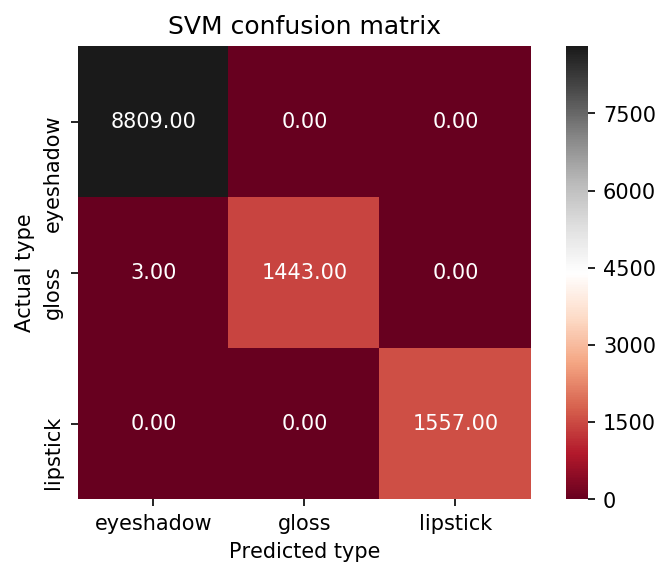

In [2478]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline
nb_conf = confusion_matrix(train['type'], clf.predict(Xtrain_vect))
plt.figure(dpi=150)
sns.heatmap(nb_conf, cmap=plt.cm.RdGy, annot=True, square=True,
           xticklabels=['eyeshadow','gloss','lipstick'],
           yticklabels=['eyeshadow','gloss','lipstick'],fmt='.2f')

plt.xlabel('Predicted type')
plt.ylabel('Actual type')
plt.title('SVM confusion matrix')
plt.savefig('confusion.png', bbox_inches='tight')

In [ ]:
df.iloc[2053]

In [ ]:
re.search('[0-9\.]+', '$12.00 for 0.059 oz.').group()

In [ ]:
df['price_substr'] = df['review_text'].map(lambda x: x[0:100])

In [ ]:
price0 = []
for i in df['price_substr']:
    try:
        if '.' != (re.search('[0-9\.]+', i).group()) and '.' in (re.search('[0-9\.]+', i).group()): 
            price0.append(re.search('[0-9\.]+', i).group())
        else:
            price0.append(0)
    except:
        price0.append(0)

In [ ]:
df['price'] = price0

In [ ]:
df[['product_name', 'price']].to_csv('prices.csv')

In [ ]:
df_grades = df.groupby('score').adjs.apply(lambda x: pd.DataFrame(x.values[0])).reset_index().drop('level_1', axis = 1)

In [ ]:
df_grades.head()

In [ ]:
clf.score(vectorizer.transform(Xtrain), ytrain)

In [ ]:
df.sample()